In [1]:
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB


%matplotlib inline

In [2]:
df = pd.read_excel('all.xlsx')

In [3]:
df.shape

(3840, 3)

In [4]:
df.head()

,user_name,scores,comment
0,Paromjit,5.0,Anyone who is shocked by the nightmare rise of...
1,Mary Beth,5.0,Wow! Wow! Wow! Karen Slaughter knocked this on...
2,Sandy,4.0,I’ll begin by offering a bit of advice. Don’t ...
3,Meredith,4.0,“You will be the last widow of your kind.”The ...
4,Holly B (semi-hiatus until Jan),4.0,\nSara Linton and Will Trent are back!\nThis i...


In [6]:
# 删除为空的元素
df.dropna(axis=0,inplace=True)

In [7]:
df.shape

(3783, 3)

In [8]:
stopwords = set(STOPWORDS)

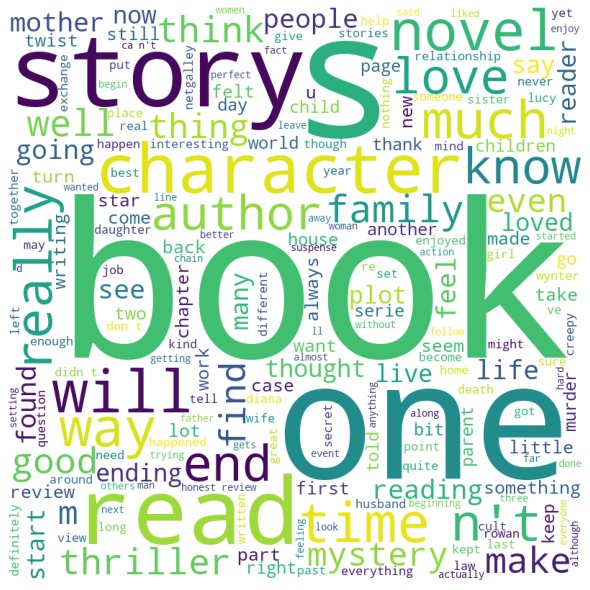

In [9]:
corpus = ''
for text in df.comment: 
    # remove url links in comments
    text = result = re.sub(r"http\S+", "", str(text))
    # split the value 
    tokens = [word.lower() for word in word_tokenize(text)]
    # adding the tokenized words into corpus
    corpus += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = "white", 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(corpus) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [10]:
# 对comment处理，转换成word list
def trans_comment(data):
    text = data['comment']
    # remove url links in comments
    text = result = re.sub(r"http\S+", "", str(text))
    # split the value 
    tokens = [word.lower() for word in word_tokenize(text)]
    # remove stopwords
    words = []
    for token in tokens:
        if token not in stopwords and token.isalnum():
            words.append(token)
    return ' '.join(words)

In [11]:
df['comment_list'] = df.apply(trans_comment,axis=1)

In [12]:
df.head()

,user_name,scores,comment,comment_list
0,Paromjit,5.0,Anyone who is shocked by the nightmare rise of...,anyone shocked nightmare rise far right nazi i...
1,Mary Beth,5.0,Wow! Wow! Wow! Karen Slaughter knocked this on...,wow wow wow karen slaughter knocked one ball p...
2,Sandy,4.0,I’ll begin by offering a bit of advice. Don’t ...,ll begin offering bit advice don t open idea g...
3,Meredith,4.0,“You will be the last widow of your kind.”The ...,will last widow last widow book 9 will trent s...
4,Holly B (semi-hiatus until Jan),4.0,\nSara Linton and Will Trent are back!\nThis i...,sara linton will trent back book 9 popular ser...


In [14]:
count_vect = CountVectorizer()
# sklearn使用稀疏矩阵记录X和Y，所以此处不能standlization
X = df['comment_list']
Y = df['scores']
# train : valid : test   = 7 : 2 : 1
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.66, random_state=42)

In [15]:
x_train = count_vect.fit_transform(x_train)
x_test = count_vect.transform(x_test)
x_valid = count_vect.transform(x_valid)

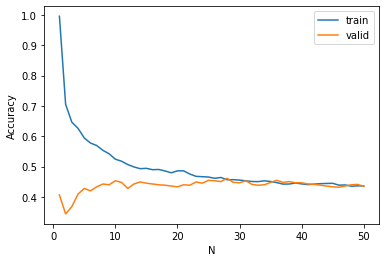

In [16]:
# KNN

max_N = 50
train_scores = []
valid_scores = []
best_train_score = 0
best_train_N = 0
best_valid_score = 0
best_valid_N = 0

for N in range(1, max_N + 1):
    model = KNeighborsClassifier(n_neighbors=N)
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    train_score = accuracy_score(train_preds, y_train)
    train_scores.append(train_score)
    if train_score > best_train_score:
        best_train_score = train_score
        best_train_N = N

    valid_preds = model.predict(x_valid)
    valid_score = accuracy_score(valid_preds, y_valid)
    valid_scores.append(valid_score)
    if valid_score > best_valid_score:
        best_valid_score = valid_score
        best_valid_N = N
plt.plot(list(range(1, max_N + 1)), train_scores, label='train')
plt.plot(list(range(1, max_N + 1)), valid_scores, label='valid')
plt.legend(loc='best')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.show()

In [18]:
print(f'the highest train accuracy is {best_train_score} when K = {best_train_N}')
print(f'the highest validation accuracy is {best_valid_score} when K = {best_valid_N}')

the highest train accuracy is 0.995845921450151 when K = 1
the highest validation accuracy is 0.4613333333333333 when K = 28


In [19]:
# print train confusion matrices
model = KNeighborsClassifier(n_neighbors=best_train_N)
model.fit(x_train, y_train)
train_preds = model.predict(x_train)
confusion_matrix(train_preds,y_train)

array([[  78,    0,    0,    0,    0],
       [   0,  160,    0,    1,    1],
       [   0,    0,  400,    0,    0],
       [   0,    0,    3,  998,    6],
       [   0,    0,    0,    0, 1001]], dtype=int64)

In [20]:
# print validation confusion matrices
model = KNeighborsClassifier(n_neighbors=best_valid_N)
model.fit(x_train, y_train)
valid_preds = model.predict(x_valid)
confusion_matrix(valid_preds,y_valid)

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   1,   2,   1,   0],
       [ 10,  29,  73, 212, 152],
       [  9,  10,  33,  86, 132]], dtype=int64)

In [21]:
# Bayes

model = GaussianNB()
model.fit(x_train.toarray(), y_train)
train_preds = model.predict(x_train.toarray())
train_score = accuracy_score(train_preds, y_train)
valid_preds = model.predict(x_valid.toarray())
valid_score = accuracy_score(valid_preds, y_valid)

In [22]:
print(f'the highest train accuracy is {train_score}')
print(f'the highest validation accuracy is {valid_score}')

the highest train accuracy is 0.8893504531722054
the highest validation accuracy is 0.4026666666666667


In [23]:
# train
confusion_matrix(train_preds,y_train)

array([[ 78,   2,  18,  31,  25],
       [  0, 158,  12,  24,  22],
       [  0,   0, 373,  50,  51],
       [  0,   0,   0, 867,  31],
       [  0,   0,   0,  27, 879]], dtype=int64)

In [21]:
confusion_matrix(valid_preds,y_valid)

array([[  1,   6,   3,  12,   8],
       [  0,   2,   3,   8,   9],
       [  4,   2,  20,  35,  21],
       [  6,  16,  47, 131,  97],
       [  8,  14,  35, 113, 149]])

In [22]:
# Lasso Regression

best_train_score = 0
best_train_param = 0
best_valid_score = 0
best_valid_param = 0

for alpha in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = Lasso(alpha=alpha)
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    train_preds = np.floor(train_preds + 0.5)
    train_score = accuracy_score(train_preds, y_train)
    if train_score > best_train_score:
        best_train_score = train_score
        best_train_param = alpha

    valid_preds = model.predict(x_valid)
    valid_preds = np.floor(valid_preds + 0.5)
    valid_score = accuracy_score(valid_preds, y_valid)
    valid_scores.append(valid_score)
    if valid_score > best_valid_score:
        best_valid_score = valid_score
        best_valid_param = alpha

In [23]:
print(f'the highest train accuracy is {best_train_score} when alpha = {best_train_param}')
print(f'the highest validation accuracy is {best_valid_score} when alpha = {best_valid_param}')

the highest train accuracy is 0.6839123867069486 when alpha = 0.001
the highest validation accuracy is 0.46 when alpha = 0.01


In [24]:
# print train confusion matrices
model = Lasso(alpha=best_train_param)
model.fit(x_train, y_train)
train_preds = model.predict(x_train)
train_preds = np.floor(train_preds + 0.5)
confusion_matrix(train_preds,y_train)

array([[ 16,   1,   0,   0,   0,   0],
       [ 38,  55,   9,   0,   0,   0],
       [ 20,  80, 241,  49,   0,   0],
       [  4,  24, 153, 906, 406,   0],
       [  0,   0,   0,  44, 593,   0],
       [  0,   0,   0,   0,   9,   0]])

In [25]:
# print validation confusion matrices
model = Lasso(alpha=best_valid_param)
model.fit(x_train, y_train)
valid_preds = model.predict(x_valid)
valid_preds = np.floor(valid_preds + 0.5)
confusion_matrix(valid_preds,y_valid)

array([[  0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0],
       [  8,  12,  19,   9,   2,   0],
       [ 10,  28,  89, 275, 230,   0],
       [  0,   0,   0,  15,  51,   0],
       [  0,   0,   0,   0,   1,   0]])

In [26]:
# random forest
model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(x_train,y_train)
train_preds = model.predict(x_train)
train_score = accuracy_score(train_preds,y_train)
test_preds = model.predict(x_test)
test_score = accuracy_score(test_preds,y_test)
print(train_score,test_score)

0.5083081570996979 0.44935064935064933


In [27]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [28]:
# random forest

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 6, 8, 10],
    'max_features': [1, 2, 3, 4, 5, 6, 7]
}
model = RandomForestClassifier()
clf = GridSearchCV(model, param_grid)
clf.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [29]:
results = pd.DataFrame(clf.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_features','param_max_depth']])

     rank_test_score  mean_test_score param_max_features param_max_depth
0                110         0.390865                  1               2
1                124         0.385201                  1               2
2                121         0.387458                  1               2
3                136         0.381417                  1               2
4                 77         0.399538                  2               2
5                131         0.382933                  2               2
6                113         0.389726                  2               2
7                138         0.378401                  2               2
8                139         0.375748                  3               2
9                 95         0.394639                  3               2
10               134         0.381803                  3               2
11               118         0.387474                  3               2
12               133         0.382547              

In [30]:
print(clf.best_params_)

{'max_depth': 10, 'max_features': 6, 'n_estimators': 200}


In [31]:
model = RandomForestClassifier(max_depth=clf.best_params_['max_depth'],max_features=clf.best_params_['max_features'],n_estimators=clf.best_params_['n_estimators'])
model.fit(x_train,y_train)
train_preds = model.predict(x_train)
best_train_score = accuracy_score(train_preds,y_train)
valid_preds = model.predict(x_valid)
best_valid_score = accuracy_score(valid_preds,y_valid)


In [32]:
print(f'the highest train accuracy is {best_train_score} when parameters = {clf.best_params_}')
print(f'the highest validation accuracy is {best_valid_score} when parameters = {clf.best_params_}')

the highest train accuracy is 0.6404833836858006 when parameters = {'max_depth': 10, 'max_features': 6, 'n_estimators': 200}
the highest validation accuracy is 0.476 when parameters = {'max_depth': 10, 'max_features': 6, 'n_estimators': 200}


In [33]:
confusion_matrix(train_preds,y_train)

array([[  1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0],
       [ 40,  69, 213, 746,  60],
       [ 37,  91, 189, 253, 948]])

In [34]:
confusion_matrix(valid_preds,y_valid)

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 10,  19,  58, 141,  68],
       [  9,  21,  50, 158, 216]])

In [35]:
# Neural network
best_train_score = 0
best_train_param = 0
best_valid_score = 0
best_valid_param = 0

for layer_size in [100,5,3]:
    model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(layer_size), random_state=1)
    model.fit(x_train,y_train)
    train_preds = model.predict(x_train)
    train_score = accuracy_score(train_preds,y_train)
    if train_score > best_train_score:
        best_train_score = train_score
        best_train_param = layer_size

    valid_preds = model.predict(x_valid)
    valid_score = accuracy_score(valid_preds, y_valid)
    valid_scores.append(valid_score)
    if valid_score > best_valid_score:
        best_valid_score = valid_score
        best_valid_param = layer_size


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [36]:
print(f'the highest train accuracy is {best_train_score} when hidden_layer = {best_train_param}')
print(f'the highest validation accuracy is {best_valid_score} when hidden_layer = {best_valid_param}')

the highest train accuracy is 0.995845921450151 when hidden_layer = 100
the highest validation accuracy is 0.5026666666666667 when hidden_layer = 100


In [37]:
# print train confusion matrices
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(best_train_param), random_state=1)
model.fit(x_train, y_train)
train_preds = model.predict(x_train)
confusion_matrix(train_preds,y_train)

array([[  78,    0,    0,    0,    0],
       [   0,  159,    0,    0,    0],
       [   0,    0,  401,    2,    0],
       [   0,    0,    1,  995,    4],
       [   0,    1,    1,    2, 1004]])

In [38]:
# print validation confusion matrices
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(best_valid_param), random_state=1)
model.fit(x_train, y_train)
valid_preds = model.predict(x_valid)
confusion_matrix(valid_preds,y_valid)

array([[  5,   5,   2,   1,   0],
       [  6,  13,   4,   4,   8],
       [  4,  12,  42,  37,  18],
       [  3,   6,  39, 151,  92],
       [  1,   4,  21, 106, 166]])

In [39]:
model = KNeighborsClassifier(n_neighbors=best_train_N)
# model = GaussianNB()
# model = Lasso(alpha=best_train_param)
# model = RandomForestClassifier(max_depth=clf.best_params_['max_depth'],max_features=clf.best_params_['max_features'],n_estimators=clf.best_params_['n_estimators'])
# model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(best_valid_param), random_state=1)

model.fit(x_train, y_train)
test_preds = model.predict(x_test)
test_score = accuracy_score(test_preds,y_test)

In [40]:
print(f'higest test score is {test_score}')

higest test score is 0.4025974025974026
